In [37]:
# %load structure.py
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
import random
import time
from copy import deepcopy

from geometry import *
from kmeans import *

class structure(object):
    def __init__(self, n_nodes, in_area, sigma = 1,
                 xlim=[-1,1], ylim=[-1,1],  
                 n_sec_max = 100, multiplier=10, 
                 dont_print = True,
                 depth_limit = 3):
        self.dont_print = dont_print
        if n_nodes<4:
            print("error, n_nodes<1")
        self.xlim = list(xlim)
        self.ylim = list(ylim)
        self.in_area = in_area
        self.n_nodes = n_nodes
        self.G = nx.Graph()
        self.p=[]
        self.boundary_nodes = set()
        
        self.sigma = sigma
        
        self.depth_limit = depth_limit
        self.n_per_section = 0
        
    def make_points(self, n_sec_max=100, multiplier =10):
        p=[]
        sections = 1
        not_enough = True
        while not_enough:
            if self.n_nodes/sections**2<n_sec_max:
                not_enough = False
            else:
                sections+=1
        self.n_per_section = int(self.n_nodes/sections**2)
        for i in range(sections):
            y_lim = (self.ylim[0]+i/sections*(self.ylim[1]-self.ylim[0]),
                     self.ylim[0]+(i+1)/sections*(self.ylim[1]-self.ylim[0]))
            for j in range(sections):
                x_lim = (self.xlim[0]+j/sections*(self.xlim[1]-self.xlim[0]),
                         self.xlim[0]+(j+1)/sections*(self.xlim[1]-self.xlim[0]))
                
                points = []
                for n in range(self.n_per_section*multiplier):
                    a, b = np.random.random(size = 2)
                    position = np.array([x_lim[0]+ a*(x_lim[1]-x_lim[0]), y_lim[0]+ b*(y_lim[1]-y_lim[0])])    
                    points.append(position)
                
                cp = find_centers(points, self.n_per_section, iter_max=2)  #np.random.random(size = (N,2)))
                filtered_centers = []
                for point in cp[0]:
                    if self.in_area(point):
                        filtered_centers.append(point)
                p = p + filtered_centers
        print("Number of points:", len(p))
        self.n_nodes = len(p)
        for id_n,point in enumerate(p):
            self.p.append(Point(point[0], point[1]))
    def make_graph_triangulation(self):
        x = [self.p[i].x for i in range(self.n_nodes)]
        y = [self.p[i].y for i in range(self.n_nodes)]
        T = Triangulation(x,y)
        self.G = nx.Graph()
        self.G.add_edges_from(T.edges)
        
        
    def make_graph(self):
        self.G = nx.Graph()
        self.G.add_edge(0,1)
        self.G.add_edge(2,1)
        self.G.add_edge(0,2)
        self.boundary_nodes = set([0,1,2])
        for i,p in enumerate(self.p):
            if i>2:
                proxy  = self.find_closest_inside_graph_fast(i, self.p[i])
                self.G.add_node(i)
                self.G.add_edge(i, proxy)
                #self.reconnect_spatially( i, with_proxy = True, proxy = proxy, check_boundary = False)    
                if not self.dont_print: print("proxy", proxy)
                self.reconnect_properly_depth(i,depth_limit = 3, check_boundary=False, with_edge=True)
                self.boundary_check(self.G.neighbors(i))
                if self.on_edge(i):
                    self.boundary_nodes.add(i)
                
                
                if not self.dont_print: self.draw_graph()
                
                
    def find_closest_inside_graph(self, i, other_than, pool = -1):
        if pool == -1:
            pool = list(self.G.nodes())
        actual_pool = []
        for i in pool:
            if i not in other_than:
                actual_pool.append(i)
                
        if len(actual_pool)>0:
            minj = np.random.choice(actual_pool)
            for j in actual_pool:
                if self.p[i].distance(self.p[j])<self.p[i].distance(self.p[minj]):
                    minj = j
            return minj
        else:
            return -1
        

    def find_closest_inside_graph_fast(self, i, pi):
        pool = list(self.G.nodes())        
        if len(pool)>0:
            closest_found = []
            for k in range(5):
                minj = np.random.choice(pool)
                found = False
                while not found:
                    nodes = self.G.neighbors(minj)
                    new_minj = minj
                    for j in nodes:
                        if pi.distance(self.p[j])<pi.distance(self.p[minj]):
                            if i!=j:
                                new_minj = j
                    if minj==new_minj:
                        found = True
                    else:
                        minj=new_minj
                closest_found.append(minj)
            if not self.dont_print: print("find_closest_fast: closest_found, ", closest_found)
            minj = closest_found[0]
            for j in closest_found[1:]:
                if pi.distance(self.p[j])<pi.distance(self.p[minj]):
                    minj = j
            return  minj
        else:
            return -1
    def draw_points(self, ):
        fig,ax = plt.subplots(figsize =(8,8))
        plt.scatter([p.x for p in self.p],[p.y for p in self.p])
        plt.xlim(self.xlim)
        plt.ylim(self.ylim)
    
    def draw_graph(self, ax = -1, **kwargs ):
        pos = {node:(self.p[node].x,self.p[node].y) for node in self.G.nodes()}
        
        color = []
        for i in range(len(self.p)):
            if i in self.boundary_nodes: 
                color.append("r")
            else:
                color.append("b")
        my_figure = False
        if ax == -1:
            my_figure = True
            fig,ax = plt.subplots(figsize =(8,8))
        nx.draw_networkx(self.G, 
                         pos = pos,
                         node_color = color, 
                         #node_size = 180,
                         #with_labels= True,
                         #font_size = 17,
                         **kwargs)
        plt.xlim(self.xlim)
        plt.ylim(self.ylim)
        
        if my_figure: plt.show()
        
    def reconnect_all_spatially(self, pool=None, check_boundary = True, with_edge=False):
        if pool == None:
            pool = self.G.nodes()
            
        for i in pool:
            self.reconnect_spatially(i,check_boundary = check_boundary, with_edge=False)
    
    def reconnect_spatially(self, i, with_proxy = False, proxy = 0, with_edge=False, last = False, check_boundary = True):
        if not self.dont_print: print("reconnect_spatially:\n i,",i,
                                      ", with_proxy, ", with_proxy,
                                      ",proxy,",  proxy,
                                      " with_edge,", with_edge,
                                      " last,", last,
                                      "check_boundary, ",check_boundary)
        if with_proxy:
            neighbours = list(nx.all_neighbors(self.G, i))
            if neighbours!=[]:
                for j in neighbours:
                    self.G.remove_edge(i,j)
            #its a solo point:
            other_than = [i, proxy]
            
            close_nodes=set()
            for e in nx.dfs_edges(self.G, source= proxy, depth_limit = self.depth_limit):
                close_nodes.add(e[1])
            if with_edge:
                close_nodes = close_nodes.union(self.boundary_nodes)
            close_nodes = list(close_nodes)
            no_of_edges = 1
            end_of_nodes = False
            while no_of_edges<6 and not end_of_nodes:
                j = self.find_closest_inside_graph(i, other_than, pool = close_nodes)
                if j != -1:
                    other_than.append(j)
                else:
                    end_of_nodes = True
                    
            for j in other_than[1:]:
                self.G.add_edge(i,j)
            self.reconnect_properly_depth(i,check_boundary = check_boundary, last = last)
            
        else:
            neighbours = list(nx.all_neighbors(self.G, i))
            if neighbours!=[]:
                for j in neighbours:
                    self.G.remove_edge(i,j)
            #its a solo point:
            other_than = [i]
            no_of_edges = 0
            end_of_nodes = False
            while no_of_edges<6 and not end_of_nodes:
                j = self.find_closest_inside_graph(i, other_than)
                if j != -1:
                    other_than.append(j)
                else:
                    end_of_nodes = True
            for j in other_than[1:]:
                self.G.add_edge(i,j)
            self.reconnect_properly_depth(i,check_boundary = check_boundary, last = last)
        
    def reconnect_properly_depth(self, i, depth_limit = -1, last = False, check_boundary = True, with_edge=False):
        if not self.dont_print: print("reconnect_properly_depth:\n i, ",i,
                                      ", depth_limit, ", depth_limit,
                                      ", last, ", last,
                                      ", check_boundary, ",check_boundary,
                                      ", with_edge, ", with_edge)
        
        if depth_limit ==-1:
            depth_limit = self.depth_limit
        close_nodes=set()
        for e in nx.dfs_edges(self.G, source= i, depth_limit = depth_limit):
            close_nodes.add(e[1])
        if with_edge:
            close_nodes = close_nodes.union(self.boundary_nodes)
        close_nodes= list(close_nodes)
        self.reconnect_properly(i,close_nodes, last= last, check_boundary= check_boundary)
        
    def reconnect_properly(self, i,  pool, last = False, check_boundary = True):
        if not self.dont_print: print("reconnect_properly:\n i, ",i,
                                      ", pool, ", pool,
                                      ", last, ", last,
                                      ", check_boundary, ",check_boundary)
        if pool == []:
            self.reconnect_spatially(i, last = last, check_boundary = check_boundary)
        else:
            points = []
            for cn in pool:
                try:
                    points.append(self.p[cn])
                except:
                    print("error, reconnect properly", pool)
            poli = Poligon(self.p[i])
            
            poli.load_dots(points, pool)
            poli.produce_lines_from_dots()

            redundant_names = poli.kick_redundant_dots_lines()
            b_check=[]
            lost_all_edges = []
            may_have_too_many_edges=[]
            for j in pool:
                if j in redundant_names:# or self.p[j].distance(self.p[i])>self.sigma*10:
                    if self.G.has_edge(i,j):
                        self.G.remove_edge(i, j)
                        if list(self.G.neighbors(j)) == []:
                            lost_all_edges.append(j)
                else:
                    self.G.add_edge(i, j)
                    b_check.append(j)
                    may_have_too_many_edges.append(j)
                    
            for j in set(may_have_too_many_edges):
                if not last: 
                    self.reconnect_properly_depth(j,depth_limit=1, last = True ,check_boundary = check_boundary)
            for j in set(lost_all_edges):
                self.reconnect_spatially(j ,check_boundary = check_boundary, last = last)
            
            if check_boundary:
                self.boundary_check(b_check)
                if self.on_edge(i):
                    self.boundary_nodes.add(i)
    
    def reconnect_all_properly(self, last = False, check_boundary = True):
        for i in self.G.nodes():
            self.reconnect_properly_depth(i,check_boundary = check_boundary, last = last)
    
    def on_edge(self, i):
        if not self.dont_print: print("On edge started, point ", i)
        
        # check if it is on edge
        # it is on the edge if any of the limiting lines is not redundant.
        neighbours = list(nx.all_neighbors(self.G, i))
        points = []
        for neighbour in neighbours:
            points.append(self.p[neighbour])
        
        add_points = [Point(2*self.xlim[0]-self.p[i].x, self.p[i].y),
                      Point(2*self.xlim[1]-self.p[i].x, self.p[i].y),
                      Point(self.p[i].x, 2*self.ylim[0]-self.p[i].y),
                      Point(self.p[i].x, 2*self.ylim[1]-self.p[i].y)]
        for j, a_p in enumerate(add_points):    
            a_p_name = -j-1
            poli = Poligon(self.p[i])
            poli.load_dots([a_p]+points, [a_p_name]+neighbours)
            poli.produce_lines_from_dots()
        
            redundant_names = poli.kick_redundant_dots_lines()
            if not self.dont_print: print(a_p_name)
            if a_p_name not in redundant_names:
                if not self.dont_print: print("point ", i , " is on edge ",a_p_name, a_p.x, a_p.y)
                return True
        return False
    
    def boundary_check2(self,pool):
        for i in pool:
            oe = self.on_edge(i)
            if i in self.boundary_nodes:
                if not oe:
                    self.boundary_nodes.remove(i)
            else:
                if oe:
                    self.boundary_nodes.add(i)
                    
    def boundary_check(self,pool):
        for i in pool:
            if i in self.boundary_nodes:
                oe = self.on_edge(i)
                if not oe:
                    self.boundary_nodes.remove(i)
    
    def limit_check(self, x,y):
        if x<self.xlim[0]:
            self.xlim[0] = x-self.sigma
        if x>self.xlim[1]:
            self.xlim[1] = x+self.sigma
        if y<self.ylim[0]:
            self.ylim[0] = y-self.sigma
        if y>self.ylim[1]:
            self.ylim[1] = y+self.sigma
            

    def generate_new_xy(self, x0, y0):
        rx = np.random.randn()
        ry = np.random.randn()
        f = lambda x: -(np.abs(x)+0.5)*np.sign(x)
        x = x0 + f(rx)*self.sigma
        y = y0 + f(ry)*self.sigma
        return x,y
    
   
                
    def rescale_one(self, i, old_xlim, old_ylim, old_hlim, new_xlim, new_ylim, new_hlim):
        if old_hlim[0]!=old_hlim[1]:
            self.h[i] = new_hlim[0]+(self.h[i]-old_hlim[0])/(old_hlim[1]- old_hlim[0])*(new_hlim[1]- new_hlim[0])
            self.wl[i] = new_hlim[0]+(self.wl[i]-old_hlim[0])/(old_hlim[1]- old_hlim[0])*(new_hlim[1]- new_hlim[0])
        self.p[i].x = new_xlim[0]+(self.p[i].x-old_xlim[0])/(old_xlim[1]- old_xlim[0])*(new_xlim[1]- new_xlim[0])
        self.p[i].y = new_ylim[0]+(self.p[i].y-old_ylim[0])/(old_ylim[1]- old_ylim[0])*(new_ylim[1]- new_ylim[0])
        
    def rescale(self,new_xlim, new_ylim, new_hlim):
        old_xlim = deepcopy(self.xlim)
        old_ylim = deepcopy(self.ylim)
        try:
            old_hlim = [min(self.h), max(self.h)]
        except:
            old_hlim = [0,0]
        for i in self.G.nodes():
            self.rescale_one(i, old_xlim, old_ylim, old_hlim, new_xlim, new_ylim, new_hlim)
            
        self.xlim = new_xlim
        self.ylim = new_ylim
        
        

In [52]:
s = structure(5000, in_area = lambda x: True,)

In [53]:
s.make_points()

Number of points: 4992


In [54]:
t = time.time()
s.make_graph_triangulation()
print(time.time()-t)

0.16600942611694336


<IPython.core.display.Javascript object>


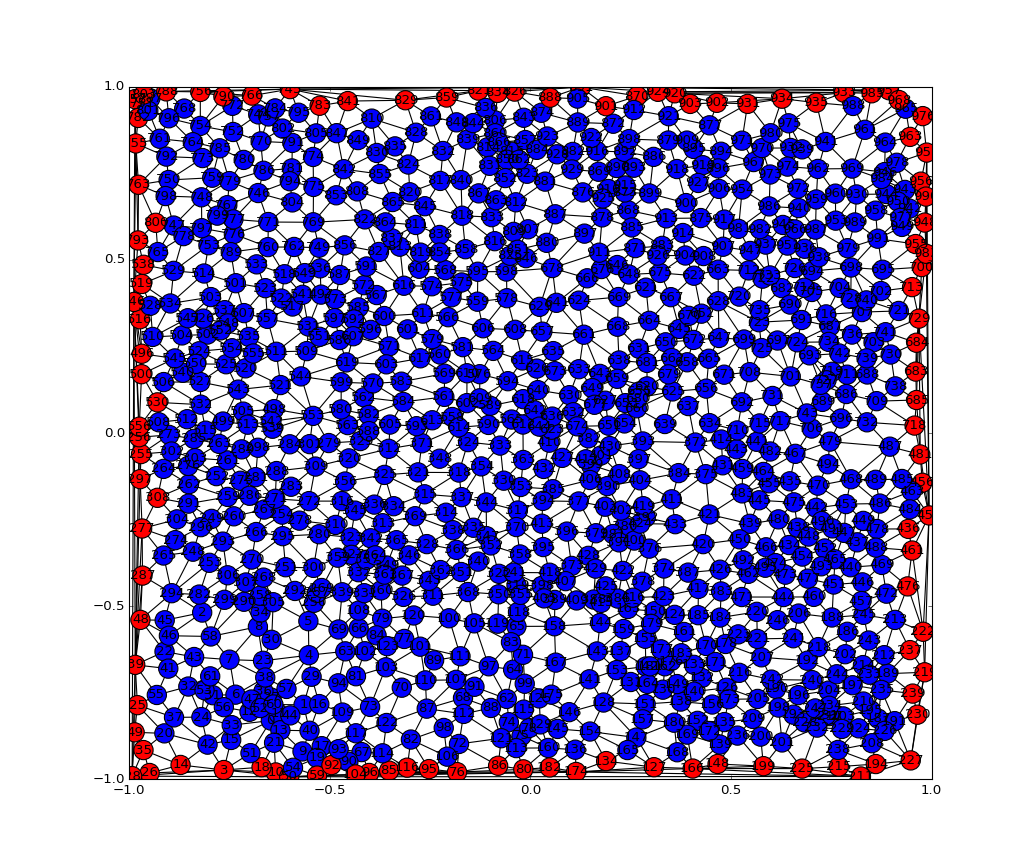

In [51]:
%matplotlib notebook

s.draw_graph()

In [48]:
s.boundary_check2(list(s.G.nodes))

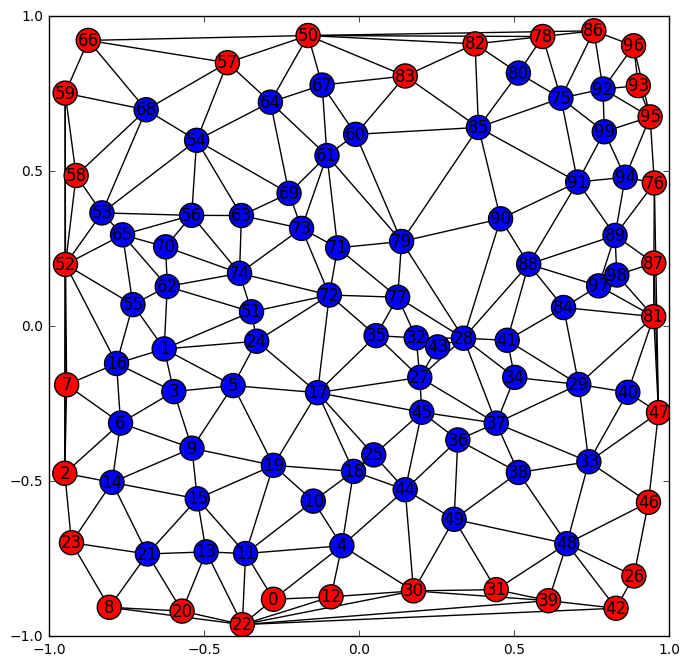

In [43]:
s.draw_graph()

In [18]:

import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

In [23]:
x, y = np.random.random(size = 10), np.random.random(size = 10)
T = Triangulation(x,y)

In [22]:
print(T.edges.T)

[[1 2 3 3 4 4 5 5 5 6 6 6 7 7 8 8 8 9 9 9]
 [0 1 0 1 1 3 1 2 4 0 1 2 0 6 2 6 7 2 5 8]]


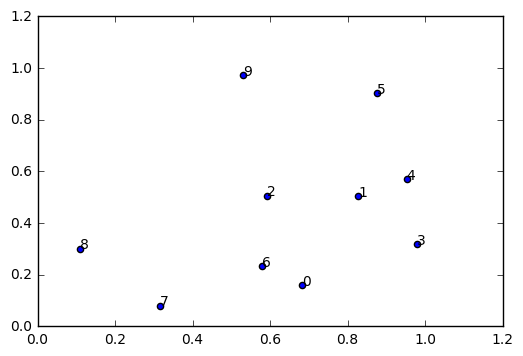

In [15]:
fig, ax = plt.subplots()
ax.scatter(x,y)
for i in range(10):
    ax.annotate(str(i), (x[i],y[i]))
plt.show()